## Predicting Peak Oil Production Rate

In this project, we will build a series of models to predict the peak oil production rate of an oil well. Predicting this quantity provides valuable
insights on the overall production profile of an oil well, which is essential for making informed decisions down the road.

## Outline

The workflow of our approach is as follows:
- Data Exploration and Pre-processing: Visualize the raw input data and observe patterns in correlation. Then, pre-process the data in a reasonable manner.
- Model Building: Construct baseline linear and non-linear models to predict the peak oil production rate.
- Evaluation: Use R-Squared and RMSE to evaluate the models and compare their performance. 
- Conclusions: Draw conclusions on performance capablity based on the evaluation phase.

## Data Exploration

There are numerous descriptive variables in our dataset. These include:
- relative_well_position
- batch_frac_classification
- frac_type
- well_family_relationship
- ffs_frac_type

First, we need to decide which of these variables we would like to keep (and which ones we want to drop).

In [20]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from typing import *

# Ignore warnings
warnings.simplefilter("ignore")

# Path to the training data
training_path = "./training.csv"

Start by reading in the training data and dropping any irrelevant features. Also, drop any rows that do not have an OilPeakRate value.

In [21]:
raw_df = pd.read_csv(training_path)
raw_df = raw_df.drop(columns=["Unnamed: 0", "pad_id", "standardized_operator_name", "surface_x", "surface_y", "bh_x", "bh_y", "horizontal_midpoint_x",
                                "horizontal_midpoint_y", "horizontal_toe_x", "horizontal_toe_y", "frac_type"])
raw_df = raw_df.dropna(subset=["OilPeakRate"])
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gross_perforated_length       19148 non-null  float64
 1   number_of_stages              2643 non-null   float64
 2   total_proppant                17912 non-null  float64
 3   total_fluid                   17866 non-null  float64
 4   true_vertical_depth           19201 non-null  float64
 5   ffs_frac_type                 14310 non-null  object 
 6   proppant_intensity            17872 non-null  float64
 7   frac_fluid_intensity          17821 non-null  float64
 8   average_stage_length          2620 non-null   float64
 9   average_proppant_per_stage    2595 non-null   float64
 10  average_frac_fluid_per_stage  2582 non-null   float64
 11  proppant_to_frac_fluid_ratio  17501 non-null  float64
 12  frac_fluid_to_proppant_ratio  17501 non-null  float64
 13  bin_la

## Preliminary Visualization

<Axes: >

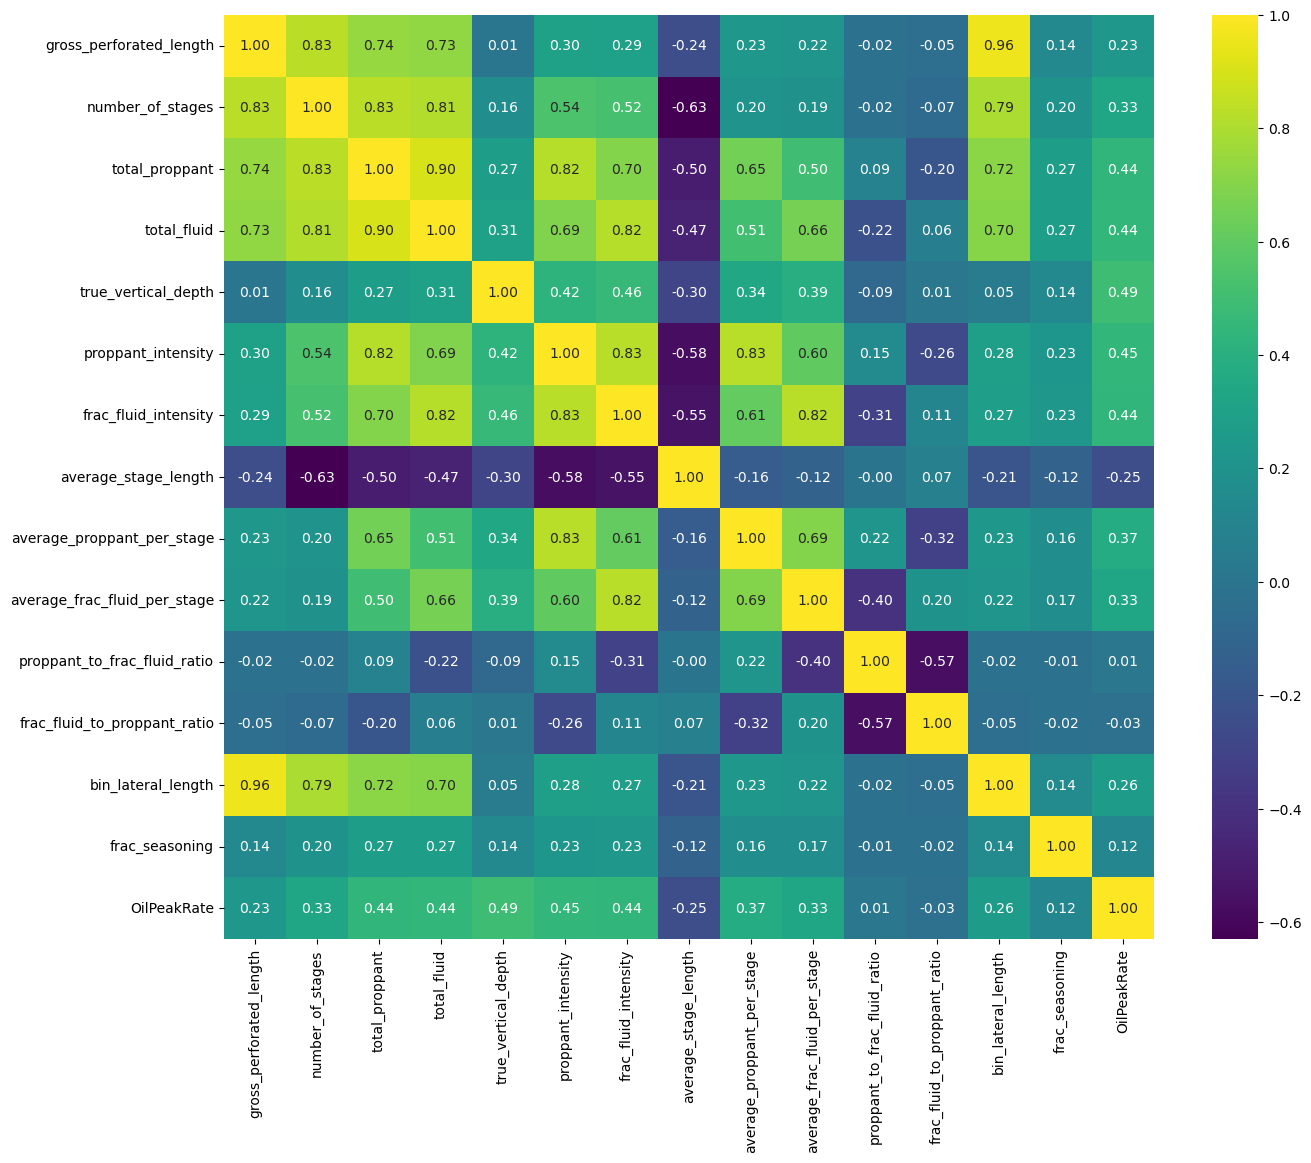

In [23]:
plt.figure(figsize=(15, 12))
# Selecting only the non-categorical variables from the DataFrame
non_categorical_data = raw_df.select_dtypes(include=[np.number])
sns.heatmap(non_categorical_data.corr(), annot=True, fmt=".2f", cmap='viridis')

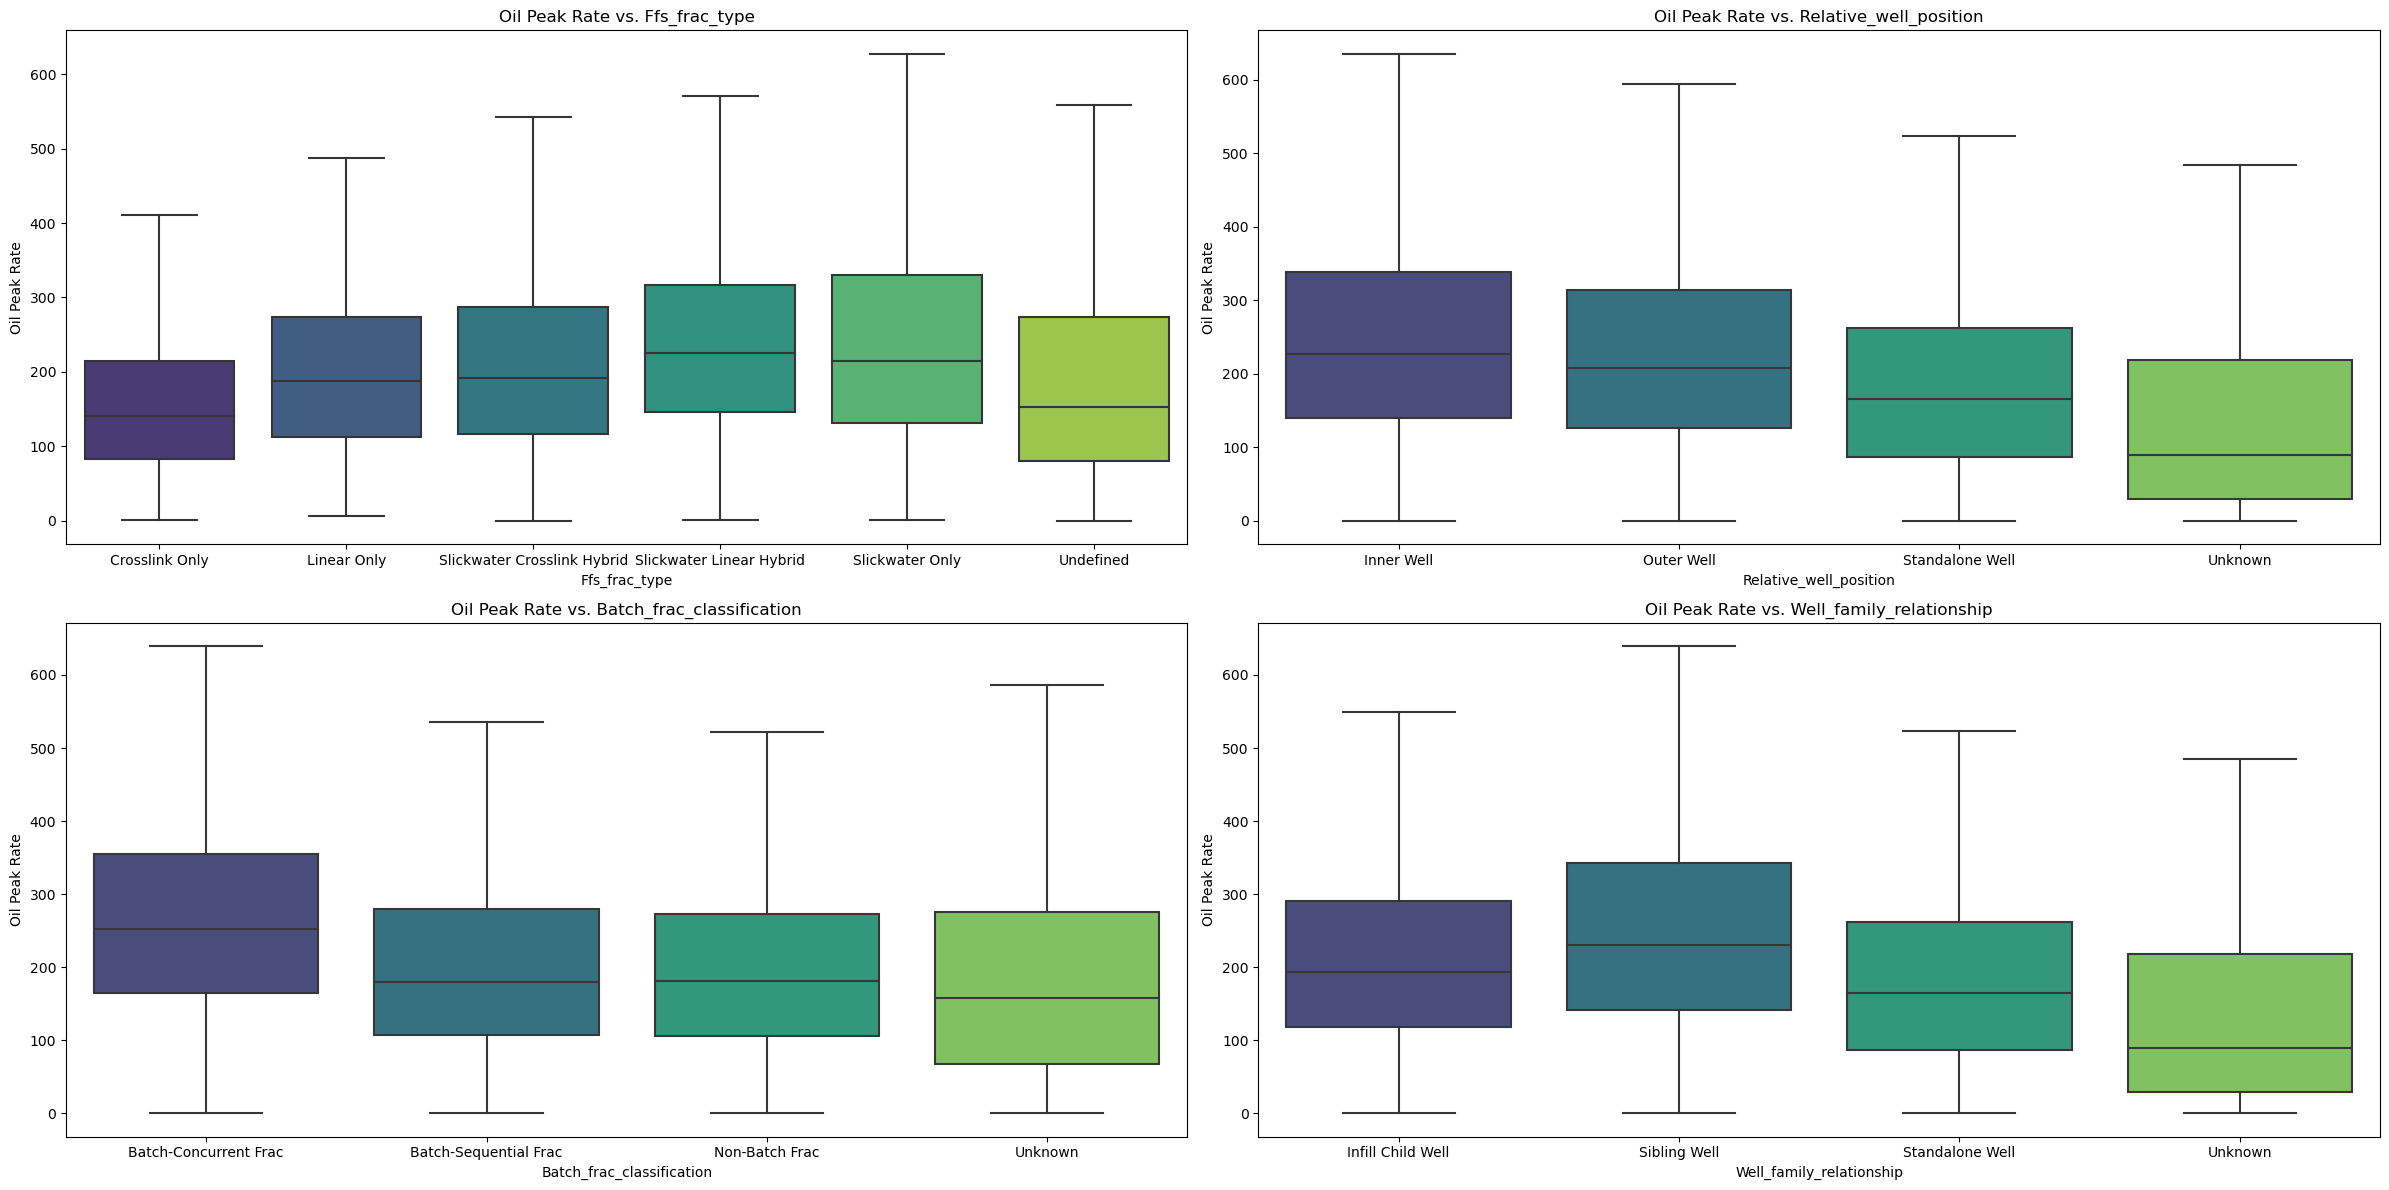

In [24]:
def visualize_categorical_variable(raw_df: pd.DataFrame, category: str, ax):
    df = raw_df.dropna(subset=[category])

    unique_values = df[category].unique()
    position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}

    # Replace the category values in the DataFrame with their corresponding numeric mappings
    df[category] = df[category].replace(position_mapping)

    # Plotting on the provided axis
    sns.boxplot(data=df, x=category, y='OilPeakRate', palette='viridis', showfliers=False, ax=ax)

    # Customizing the plot
    ax.set_title(f'Oil Peak Rate vs. {category.capitalize()}')
    ax.set_xlabel(category.capitalize())
    ax.set_ylabel('Oil Peak Rate')

    ax.set_xticks(range(len(position_mapping)))
    ax.set_xticklabels(list(position_mapping.keys()))

fig, axs = plt.subplots(2, 2, figsize=(24, 12))

# Use the modified function to plot each category in one of the subplots
visualize_categorical_variable(raw_df, "ffs_frac_type", axs[0, 0])
visualize_categorical_variable(raw_df, "relative_well_position", axs[0, 1])
visualize_categorical_variable(raw_df, "batch_frac_classification", axs[1, 0])
visualize_categorical_variable(raw_df, "well_family_relationship", axs[1, 1])

# Adjust layout for better readability
plt.tight_layout()
plt.show()

We decided to drop ffs_frac_type and relative_well_position because we felt that these variables were either redudant with other variables and/or
didn't provide too much valuable information.

In [25]:
raw_df = raw_df.drop(columns=["ffs_frac_type", "relative_well_position"])
unique_values = raw_df["batch_frac_classification"].unique()
position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}

raw_df["batch_frac_classification"] = raw_df["batch_frac_classification"].replace(position_mapping)
unique_values = raw_df["well_family_relationship"].unique()
position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}
raw_df["well_family_relationship"] = raw_df["well_family_relationship"].replace(position_mapping)

In [26]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gross_perforated_length       19148 non-null  float64
 1   number_of_stages              2643 non-null   float64
 2   total_proppant                17912 non-null  float64
 3   total_fluid                   17866 non-null  float64
 4   true_vertical_depth           19201 non-null  float64
 5   proppant_intensity            17872 non-null  float64
 6   frac_fluid_intensity          17821 non-null  float64
 7   average_stage_length          2620 non-null   float64
 8   average_proppant_per_stage    2595 non-null   float64
 9   average_frac_fluid_per_stage  2582 non-null   float64
 10  proppant_to_frac_fluid_ratio  17501 non-null  float64
 11  frac_fluid_to_proppant_ratio  17501 non-null  float64
 12  bin_lateral_length            19148 non-null  float64
 13  batch_

In [28]:
# Define a threshold for identifying high correlations
threshold = 0.8
correlation_matrix = raw_df.corr()

# Find pairs with correlation greater than the threshold
high_correlations = [(column, index, correlation_matrix[column][index]) 
                     for column in correlation_matrix.columns 
                     for index in correlation_matrix.columns 
                     if (column != index) and (abs(correlation_matrix[column][index]) > threshold)]

# Print the pairs and their correlation values
for col, idx, corr in high_correlations:
    print(f"{col} and {idx} have a correlation of {corr:.2f}")


gross_perforated_length and number_of_stages have a correlation of 0.83
gross_perforated_length and bin_lateral_length have a correlation of 0.96
number_of_stages and gross_perforated_length have a correlation of 0.83
number_of_stages and total_proppant have a correlation of 0.84
number_of_stages and total_fluid have a correlation of 0.81
total_proppant and number_of_stages have a correlation of 0.84
total_proppant and proppant_intensity have a correlation of 0.93
total_fluid and number_of_stages have a correlation of 0.81
total_fluid and frac_fluid_intensity have a correlation of 0.83
proppant_intensity and total_proppant have a correlation of 0.93
proppant_intensity and average_proppant_per_stage have a correlation of 0.80
frac_fluid_intensity and total_fluid have a correlation of 0.83
average_proppant_per_stage and proppant_intensity have a correlation of 0.80
bin_lateral_length and gross_perforated_length have a correlation of 0.96


<Axes: xlabel='number_of_stages', ylabel='gross_perforated_length'>

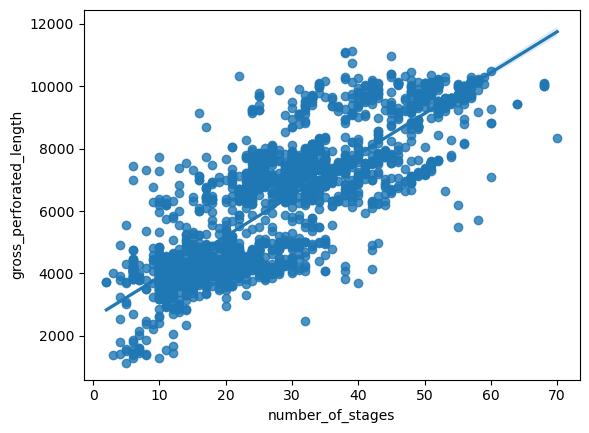

In [30]:
sns.regplot(x='number_of_stages', y='gross_perforated_length', data=raw_df, fit_reg=True)

## Model Building

First, we attempt to build a model that only includes rows with all available data.

In [99]:
from sklearn.model_selection import train_test_split
all_variables_df = raw_df.dropna()

print(all_variables_df.info())
X = all_variables_df.drop(["OilPeakRate"], axis=1)
y = all_variables_df["OilPeakRate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=76)
train_data = X_train.join(y_train)
test_data = X_test.join(y_test)

train_data

<class 'pandas.core.frame.DataFrame'>
Index: 2296 entries, 2 to 29431
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gross_perforated_length       2296 non-null   float64
 1   number_of_stages              2296 non-null   float64
 2   total_proppant                2296 non-null   float64
 3   total_fluid                   2296 non-null   float64
 4   true_vertical_depth           2296 non-null   float64
 5   proppant_intensity            2296 non-null   float64
 6   frac_fluid_intensity          2296 non-null   float64
 7   average_stage_length          2296 non-null   float64
 8   average_proppant_per_stage    2296 non-null   float64
 9   average_frac_fluid_per_stage  2296 non-null   float64
 10  proppant_to_frac_fluid_ratio  2296 non-null   float64
 11  frac_fluid_to_proppant_ratio  2296 non-null   float64
 12  bin_lateral_length            2296 non-null   float64
 13  batch_f

,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,average_stage_length,average_proppant_per_stage,average_frac_fluid_per_stage,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,batch_frac_classification,well_family_relationship,frac_seasoning,OilPeakRate
8696,7503.937008,32.0,5.216351e+05,2016600.503,6049.212598,69.514852,268.738997,234.498031,16301.09598,63018.76571,0.258671,3.865922,1.5,0,1,34.0,80.369060
9055,6643.700787,47.0,9.152399e+05,5503430.852,7119.094488,137.760547,828.368259,141.355336,19473.18845,117094.27340,0.166304,6.013102,1.5,2,2,52.0,77.819853
18760,7569.881890,51.0,8.716013e+05,5080373.786,9547.244094,115.140672,671.129862,148.429057,17090.22129,99615.17228,0.171562,5.828782,1.5,2,2,49.0,161.655184
1793,3671.259843,23.0,4.817620e+05,2774453.929,10407.480310,131.225252,755.722572,159.619993,20946.17391,120628.43170,0.173642,5.758972,1.0,2,2,22.0,213.088128
13981,4055.118110,17.0,1.942857e+05,1177744.801,8026.574803,47.911234,290.434155,238.536359,11428.57143,69279.10596,0.164964,6.061922,1.0,2,2,299.0,64.161575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9389,9914.370079,43.0,8.437322e+05,5580830.114,9590.551181,85.101949,562.903147,230.566746,19621.67940,129786.74680,0.151184,6.614457,2.0,2,2,12.0,212.778128
14399,6425.196850,32.0,1.305992e+06,5025255.778,11157.480310,203.261032,782.117014,200.787402,40812.25446,157039.24310,0.259886,3.847845,1.5,2,2,74.0,367.622168
14793,6705.708661,39.0,7.668614e+05,2607027.332,11502.952760,114.359491,388.777304,171.941248,19663.11355,66846.85467,0.294152,3.399607,1.5,0,1,83.0,425.678637
25245,4558.070866,24.0,6.876629e+05,4265313.910,10511.811020,150.867083,935.771741,189.919619,28652.61905,177721.41290,0.161222,6.202624,1.0,0,1,42.0,237.181652


array([[<Axes: title={'center': 'gross_perforated_length'}>,
        <Axes: title={'center': 'number_of_stages'}>,
        <Axes: title={'center': 'total_proppant'}>,
        <Axes: title={'center': 'total_fluid'}>],
       [<Axes: title={'center': 'true_vertical_depth'}>,
        <Axes: title={'center': 'proppant_intensity'}>,
        <Axes: title={'center': 'frac_fluid_intensity'}>,
        <Axes: title={'center': 'average_stage_length'}>],
       [<Axes: title={'center': 'average_proppant_per_stage'}>,
        <Axes: title={'center': 'average_frac_fluid_per_stage'}>,
        <Axes: title={'center': 'proppant_to_frac_fluid_ratio'}>,
        <Axes: title={'center': 'frac_fluid_to_proppant_ratio'}>],
       [<Axes: title={'center': 'bin_lateral_length'}>,
        <Axes: title={'center': 'batch_frac_classification'}>,
        <Axes: title={'center': 'well_family_relationship'}>,
        <Axes: title={'center': 'frac_seasoning'}>],
       [<Axes: title={'center': 'OilPeakRate'}>, <Axes: 

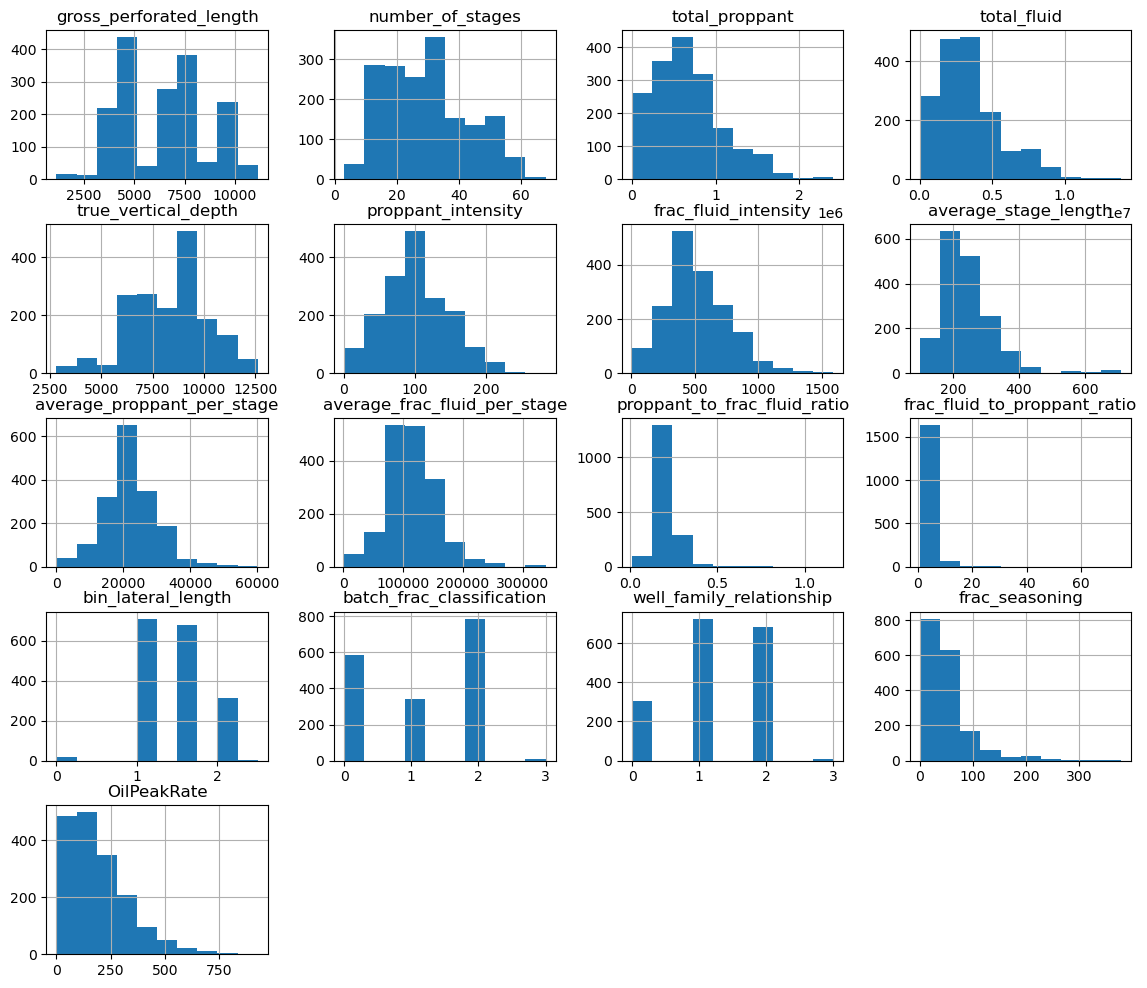

In [100]:
train_data.hist(figsize=(14, 12))

Start with a basic linear regression model

In [101]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Scale the input data
scaler = StandardScaler()
x_train, y_train = train_data.drop(["OilPeakRate"], axis=1), train_data["OilPeakRate"]
X_train_s = scaler.fit_transform(x_train)
X_test_s = scaler.transform(X_test) 

# Fit a Lasso Regression model
alpha = 0.05
lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train_s, y_train)

Lasso(alpha=0.05)

In [102]:
lasso_score = round(lasso_reg.score(X_test_s, y_test), 3)
lasso_score

0.411

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

forest = RandomForestRegressor()

"""
param_dist = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
random_search = RandomizedSearchCV(estimator=forest, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_s, y_train)
best_params = random_search.best_params_
print("Best parameters found: ", best_params)
best_forest = RandomForestRegressor(**best_params)"""

# Fit the model with the best parameters
forest.fit(X_train_s, y_train)

RandomForestRegressor()

In [104]:
forest_score = round(forest.score(X_test_s, y_test), 3)
forest_score

0.622

In [105]:
from sklearn.metrics import mean_squared_error
y_pred = forest.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the RMSE
print("Root Mean Squared Error (RMSE):", round(rmse, 3))

Root Mean Squared Error (RMSE): 78.9
